In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
import xgboost as xgb
import lightgbm as lgb
import networkx as nx
from collections import defaultdict
from scipy import sparse
from scipy.stats import pointbiserialr, chi2_contingency

In [5]:
GsArticles = '../raw_data/oa_gs_articles.csv'
GSFaurls = '../raw_data/oa_gs_fa_urls.csv'
GsGoldJournals = '../raw_data/oa_gs_gold_journals.csv'
GsHostTypes = '../raw_data/oa_gs_host_types.csv'
GsLicenses = '../raw_data/oa_gs_licenses.csv'
GsWosScMapping = '../raw_data/oa_gs_wos_sc_mapping.csv'

raw_gsarticles = pd.read_csv(GsArticles)
raw_GSFaurls = pd.read_csv(GSFaurls)
#raw_GsGoldJournals = pd.read_csv(GsGoldJournals)    #Remove
#raw_GsHostTypes = pd.read_csv(GsHostTypes)  #Remove
raw_GsLicenses = pd.read_csv(GsLicenses)
raw_GsWosScMapping = pd.read_csv(GsWosScMapping, delimiter=";")  # If it's semicolon-separated

In [6]:
raw1 = raw_gsarticles
raw2 = raw_GSFaurls
raw3 = raw_GsLicenses
raw4 = raw_GsWosScMapping



In [7]:
raw1.head()

,doi,doc_type,journal,pub_year
0,10.0016/j.jcv.2009.07.001,Article,JOURNAL OF CLINICAL VIROLOGY,2009
1,10.1001/archneurol.2009.15,Review,ARCHIVES OF NEUROLOGY,2009
2,10.1001/jama.2009.7,Article,JAMA-JOURNAL OF THE AMERICAN MEDICAL ASSOCIATION,2009
3,10.1001/jama.2013.282025,Review,JAMA-JOURNAL OF THE AMERICAN MEDICAL ASSOCIATION,2014
4,10.1001/jama.2013.282034,Article,JAMA-JOURNAL OF THE AMERICAN MEDICAL ASSOCIATION,2014


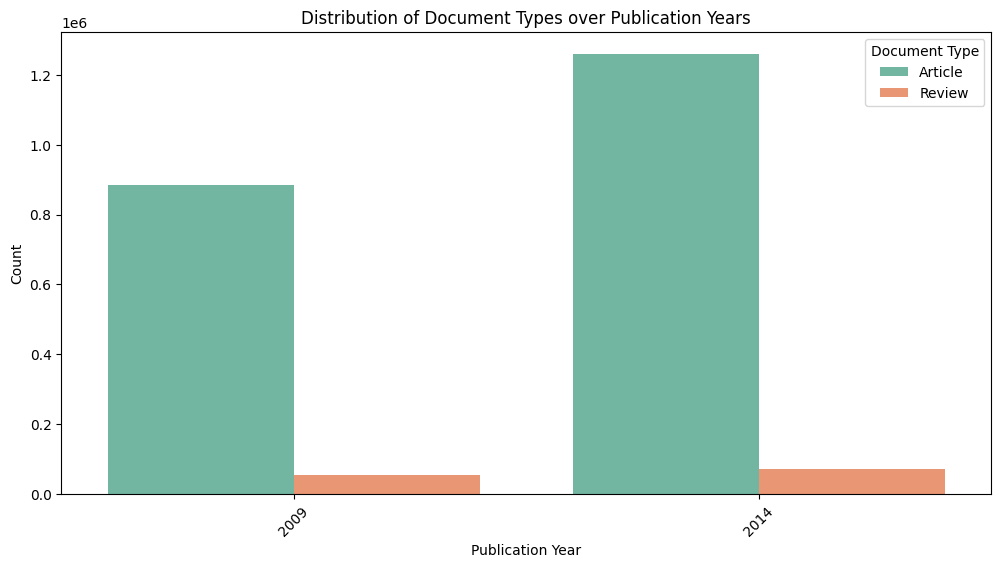

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(data=raw1, x='pub_year', hue='doc_type', palette='Set2')

plt.xlabel('Publication Year')
plt.ylabel('Count')
plt.title('Distribution of Document Types over Publication Years')
plt.xticks(rotation=45)
plt.legend(title='Document Type')
plt.show()

In [9]:
raw2.head()

,doi,fa_url,host,prim_fa_url,host_type,oa_type,only_source
0,10.1001/archneurol.2009.15,http://archinte.jamanetwork.com/article.aspx?a...,archinte.jamanetwork.com,True,publisher,bronze,NaN
1,10.1001/archneurol.2009.15,http://archneur.jamanetwork.com/article.aspx?a...,archneur.jamanetwork.com,False,publisher,bronze,NaN
2,10.1001/archneurol.2009.15,http://archneur.jamanetwork.com/article.aspx?a...,archneur.jamanetwork.com,False,publisher,bronze,NaN
3,10.1001/archneurol.2009.15,http://archopht.jamanetwork.com/article.aspx?a...,archopht.jamanetwork.com,False,publisher,bronze,NaN
4,10.1001/archneurol.2009.15,http://archotol.jamanetwork.com/article.aspx?a...,archotol.jamanetwork.com,False,publisher,bronze,NaN


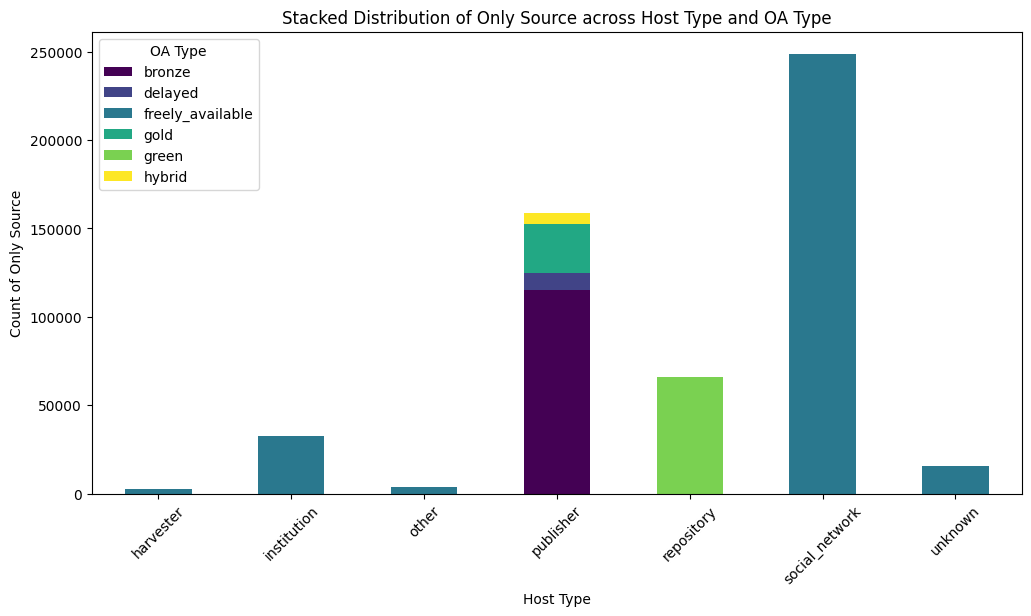

In [10]:
df_grouped = raw2.groupby(['host_type', 'oa_type'])['only_source'].sum().unstack()

df_grouped.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

plt.xlabel('Host Type')
plt.ylabel('Count of Only Source')
plt.title('Stacked Distribution of Only Source across Host Type and OA Type')
plt.legend(title='OA Type')
plt.xticks(rotation=45)
plt.show()


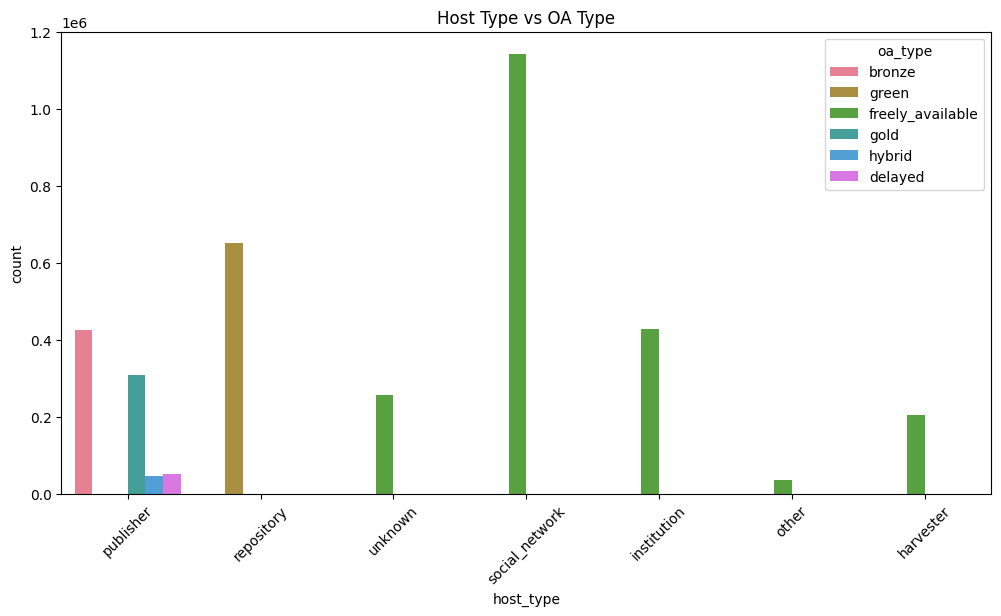

In [11]:
plt.figure(figsize=(12,6))
sns.countplot(x='host_type', hue='oa_type', data=raw2, palette='husl')
plt.xticks(rotation=45)
plt.title("Host Type vs OA Type")
plt.show()

In [12]:
raw3.head()

,doi,license,delay,license_provenance,open_access_license
0,10.1001/jama.2009.7,no license found,NaN,crossref,False
1,10.1001/jama.2013.282034,no license found,NaN,crossref,False
2,10.1001/jama.2013.282538,no license found,NaN,crossref,False
3,10.1001/archneurol.2009.15,no license found,NaN,crossref,False
4,10.1001/jama.2013.282025,no license found,NaN,crossref,False


C:\Users\DellLocal\AppData\Local\Temp\ipykernel_52708\894323298.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='license', y='delay', data=raw3, palette='viridis')


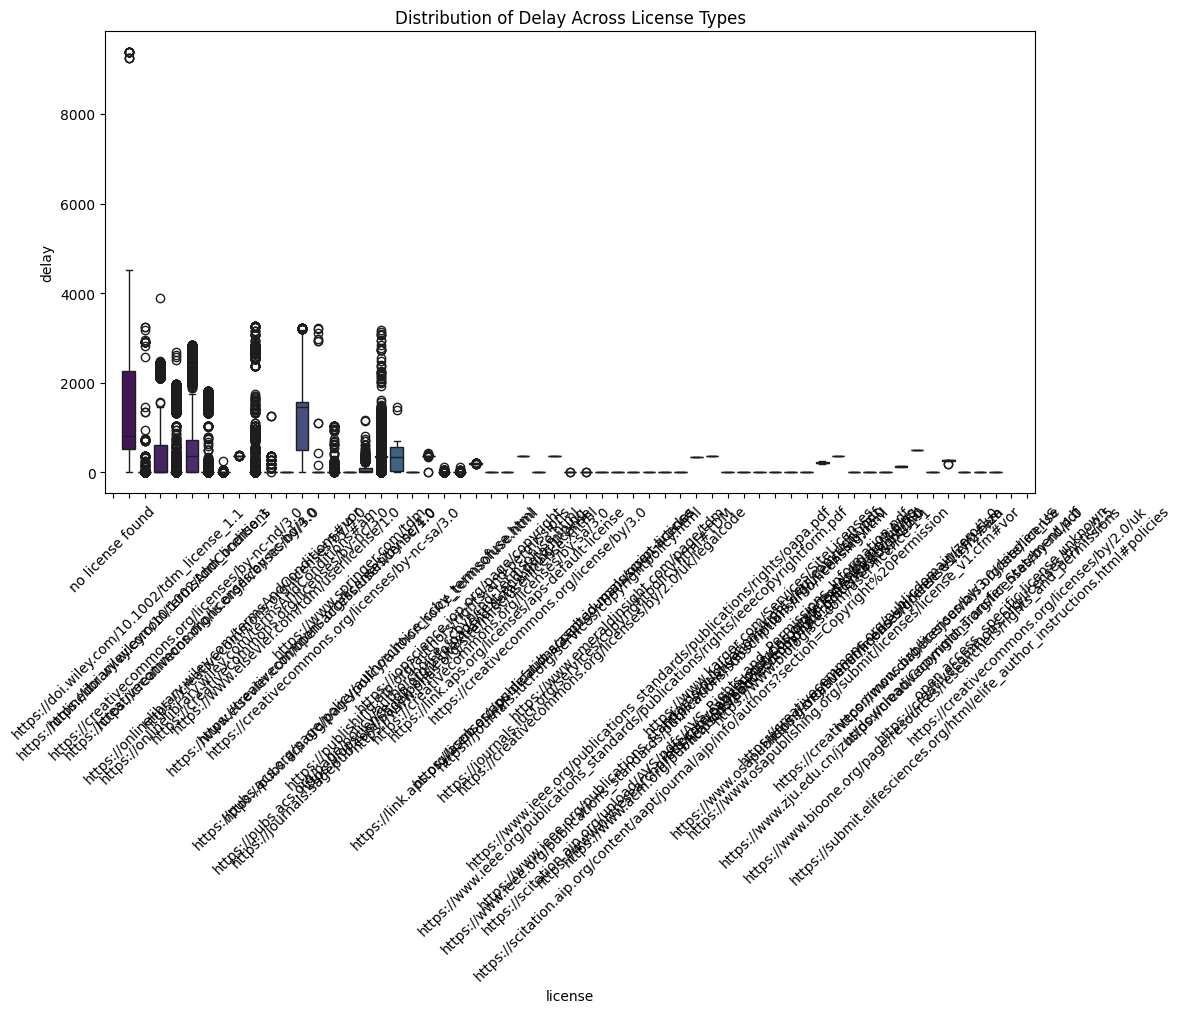

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x='license', y='delay', data=raw3, palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribution of Delay Across License Types")
plt.show()

C:\Users\DellLocal\AppData\Local\Temp\ipykernel_52708\3649551452.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='open_access_license', y='delay', data=raw3, palette='coolwarm')


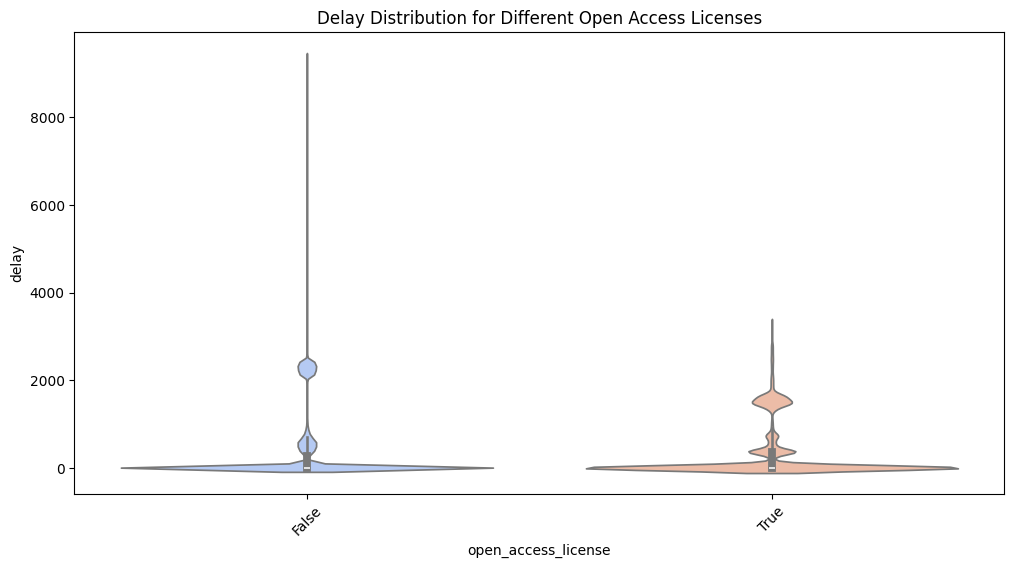

In [14]:
plt.figure(figsize=(12,6))
sns.violinplot(x='open_access_license', y='delay', data=raw3, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Delay Distribution for Different Open Access Licenses")
plt.show()

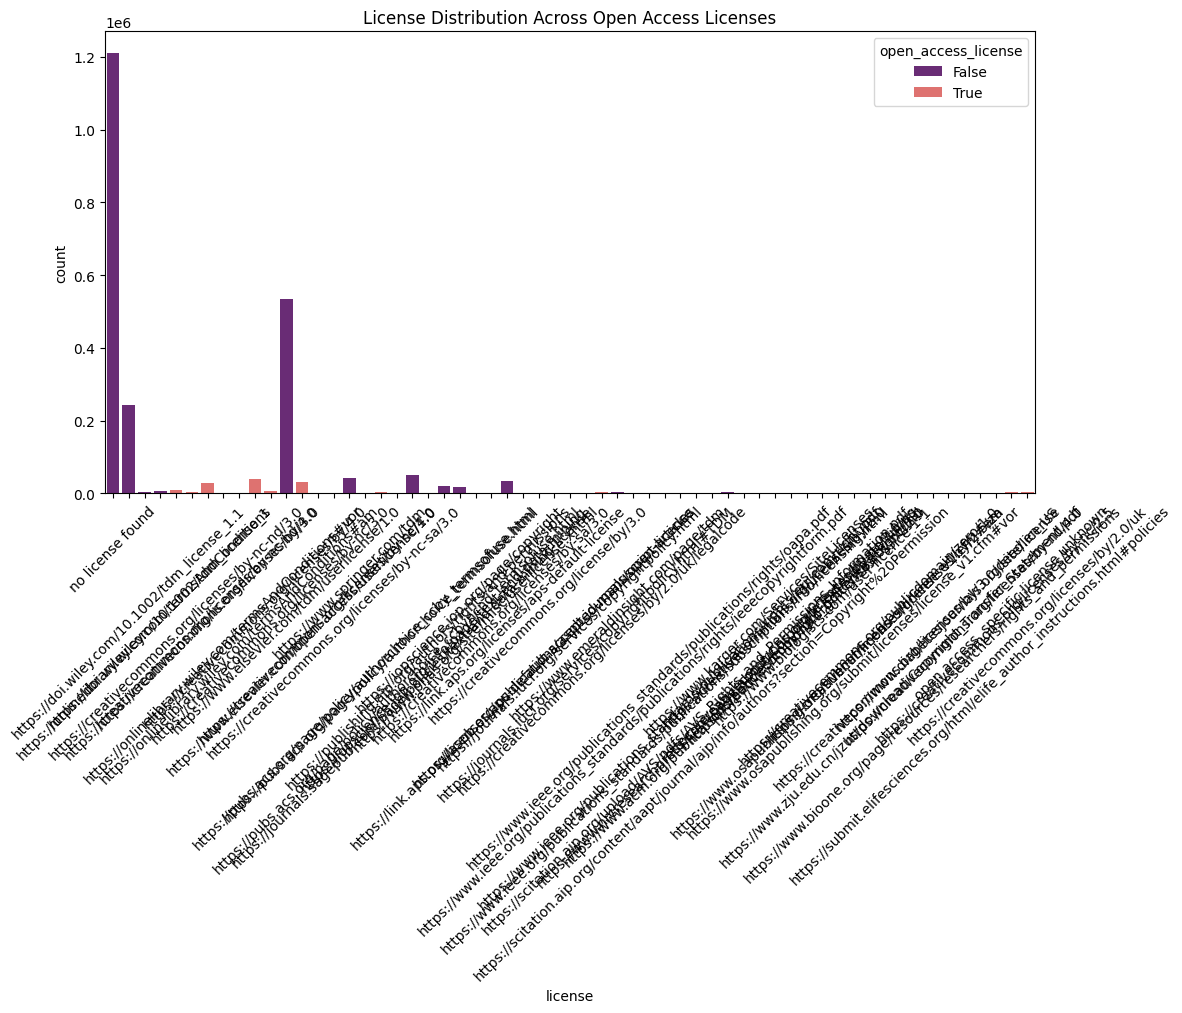

In [15]:
plt.figure(figsize=(12,6))
sns.countplot(x='license', hue='open_access_license', data=raw3, palette='magma')
plt.xticks(rotation=45)
plt.title("License Distribution Across Open Access Licenses")
plt.show()

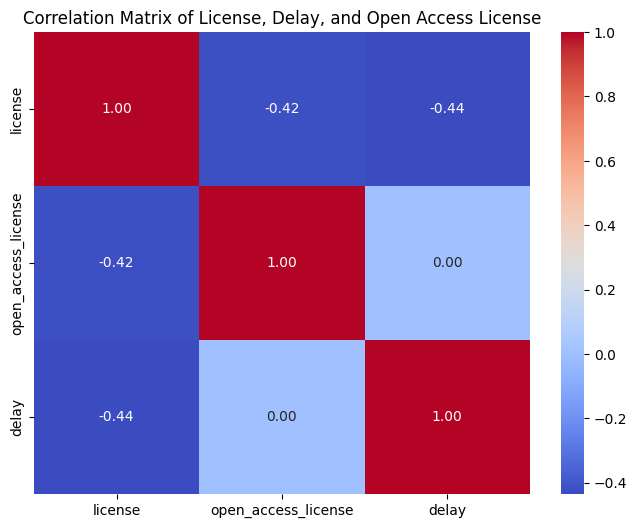

In [16]:
from scipy.stats import pointbiserialr

# Encode categorical variables
df_encoded = raw3.copy()
for col in ['license', 'open_access_license']:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Compute correlation
corr_matrix = df_encoded[['license', 'open_access_license', 'delay']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of License, Delay, and Open Access License")
plt.show()


In [17]:
raw4.head()

,wos_sc,low_nowt,middle_nowt,high_nowt
0,ACOUSTICS,MECHANICAL ENGINEERING AND AEROSPACE,ENGINEERING SCIENCES,ENGINEERING SCIENCES
1,AGRICULTURAL ECONOMICS & POLICY,ECONOMICS AND BUSINESS,"ECONOMICS, MANAGEMENT AND PLANNING",SOCIAL AND BEHAVIORAL SCIENCES
2,AGRICULTURAL ENGINEERING,AGRICULTURE AND FOOD SCIENCE,LIFE SCIENCES,MEDICAL AND LIFE SCIENCES
3,"AGRICULTURE, DAIRY & ANIMAL SCIENCE",AGRICULTURE AND FOOD SCIENCE,LIFE SCIENCES,MEDICAL AND LIFE SCIENCES
4,"AGRICULTURE, MULTIDISCIPLINARY",AGRICULTURE AND FOOD SCIENCE,LIFE SCIENCES,MEDICAL AND LIFE SCIENCES


In [18]:
raw4.shape

(252, 4)

In [19]:
raw4['wos_sc'].nunique(),raw4['low_nowt'].nunique(),raw4['middle_nowt'].nunique(),raw4['high_nowt'].nunique()

(252, 35, 14, 7)

In [20]:
df1 = pd.merge(raw1,raw2,on='doi',how='inner')
df1.head()

,doi,doc_type,journal,pub_year,fa_url,host,prim_fa_url,host_type,oa_type,only_source
0,10.1001/archneurol.2009.15,Review,ARCHIVES OF NEUROLOGY,2009,http://archinte.jamanetwork.com/article.aspx?a...,archinte.jamanetwork.com,True,publisher,bronze,NaN
1,10.1001/archneurol.2009.15,Review,ARCHIVES OF NEUROLOGY,2009,http://archneur.jamanetwork.com/article.aspx?a...,archneur.jamanetwork.com,False,publisher,bronze,NaN
2,10.1001/archneurol.2009.15,Review,ARCHIVES OF NEUROLOGY,2009,http://archneur.jamanetwork.com/article.aspx?a...,archneur.jamanetwork.com,False,publisher,bronze,NaN
3,10.1001/archneurol.2009.15,Review,ARCHIVES OF NEUROLOGY,2009,http://archopht.jamanetwork.com/article.aspx?a...,archopht.jamanetwork.com,False,publisher,bronze,NaN
4,10.1001/archneurol.2009.15,Review,ARCHIVES OF NEUROLOGY,2009,http://archotol.jamanetwork.com/article.aspx?a...,archotol.jamanetwork.com,False,publisher,bronze,NaN


In [21]:
df2 = pd.merge(raw3,df1,on='doi',how='inner')
df2.head()

,doi,license,delay,license_provenance,open_access_license,doc_type,journal,pub_year,fa_url,host,prim_fa_url,host_type,oa_type,only_source
0,10.1001/jama.2009.7,no license found,NaN,crossref,False,Article,JAMA-JOURNAL OF THE AMERICAN MEDICAL ASSOCIATION,2009,http://archderm.jamanetwork.com/article.aspx?a...,archderm.jamanetwork.com,False,publisher,bronze,NaN
1,10.1001/jama.2009.7,no license found,NaN,crossref,False,Article,JAMA-JOURNAL OF THE AMERICAN MEDICAL ASSOCIATION,2009,http://archinte.jamanetwork.com/article.aspx?a...,archinte.jamanetwork.com,False,publisher,bronze,NaN
2,10.1001/jama.2009.7,no license found,NaN,crossref,False,Article,JAMA-JOURNAL OF THE AMERICAN MEDICAL ASSOCIATION,2009,http://archpedi.jamanetwork.com/article.aspx?a...,archpedi.jamanetwork.com,False,publisher,bronze,NaN
3,10.1001/jama.2009.7,no license found,NaN,crossref,False,Article,JAMA-JOURNAL OF THE AMERICAN MEDICAL ASSOCIATION,2009,http://archpsyc.jamanetwork.com/article.aspx?a...,archpsyc.jamanetwork.com,False,publisher,bronze,NaN
4,10.1001/jama.2009.7,no license found,NaN,crossref,False,Article,JAMA-JOURNAL OF THE AMERICAN MEDICAL ASSOCIATION,2009,http://download.bioon.com/view/upload/month_09...,download.bioon.com,False,unknown,freely_available,NaN


In [22]:
df2.isna().sum()

doi                          0
license                      0
delay                  1884557
license_provenance           0
open_access_license          0
doc_type                     0
journal                      0
pub_year                     0
fa_url                       0
host                       371
prim_fa_url                  0
host_type                    0
oa_type                      0
only_source            3078461
dtype: int64

In [23]:
df2.shape

(3746129, 14)

In [24]:
df = df2.dropna()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317598 entries, 5689 to 3685621
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   doi                  317598 non-null  object 
 1   license              317598 non-null  object 
 2   delay                317598 non-null  float64
 3   license_provenance   317598 non-null  object 
 4   open_access_license  317598 non-null  bool   
 5   doc_type             317598 non-null  object 
 6   journal              317598 non-null  object 
 7   pub_year             317598 non-null  int64  
 8   fa_url               317598 non-null  object 
 9   host                 317598 non-null  object 
 10  prim_fa_url          317598 non-null  bool   
 11  host_type            317598 non-null  object 
 12  oa_type              317598 non-null  object 
 13  only_source          317598 non-null  object 
dtypes: bool(2), float64(1), int64(1), object(10)
memory usage: 32.1+ MB


In [26]:
df.sample(10)

,doi,license,delay,license_provenance,open_access_license,doc_type,journal,pub_year,fa_url,host,prim_fa_url,host_type,oa_type,only_source
1122534,10.1111/ene.12251,https://doi.wiley.com/10.1002/tdm_license_1.1,740.0,crossref,False,Article,EUROPEAN JOURNAL OF NEUROLOGY,2014,https://www.researchgate.net/profile/Hong_Kim4...,www.researchgate.net,False,social_network,freely_available,False
1093665,10.1111/1462-2920.12421,https://doi.wiley.com/10.1002/tdm_license_1.1,517.0,crossref,False,Article,ENVIRONMENTAL MICROBIOLOGY,2014,https://www.researchgate.net/profile/Alejandro...,www.researchgate.net,True,social_network,freely_available,True
1589088,10.1177/1368430209105045,https://journals.sagepub.com/page/policies/tex...,0.0,crossref,False,Article,GROUP PROCESSES & INTERGROUP RELATIONS,2009,https://www.researchgate.net/profile/Wolfgang_...,www.researchgate.net,True,social_network,freely_available,True
1150145,10.1111/j.1365-2834.2008.00958.x,https://doi.wiley.com/10.1002/tdm_license_1.1,2344.0,crossref,False,Review,JOURNAL OF NURSING MANAGEMENT,2009,http://www.academia.edu/download/45717633/j.13...,www.academia.edu,True,social_network,freely_available,True
3581933,10.1016/j.omega.2013.03.002,https://www.elsevier.com/tdm/userlicense/1.0,0.0,crossref,False,Article,OMEGA-INTERNATIONAL JOURNAL OF MANAGEMENT SCIENCE,2014,https://www.researchgate.net/profile/Qian_Long...,www.researchgate.net,True,social_network,freely_available,True
3479784,10.1016/j.jvs.2013.10.050,https://www.elsevier.com/tdm/userlicense/1.0,0.0,crossref,False,Article,JOURNAL OF VASCULAR SURGERY,2014,http://www.sciencedirect.com/science/article/p...,www.sciencedirect.com,True,publisher,delayed,True
68942,10.1002/ejoc.200900813,https://doi.wiley.com/10.1002/tdm_license_1.1,2100.0,crossref,False,Article,EUROPEAN JOURNAL OF ORGANIC CHEMISTRY,2009,https://www.researchgate.net/profile/Sven_Stad...,www.researchgate.net,False,social_network,freely_available,False
1137927,10.1111/j.1365-2141.2009.07873.x,https://doi.wiley.com/10.1002/tdm_license_1.1,2130.0,crossref,False,Article,BRITISH JOURNAL OF HAEMATOLOGY,2009,http://onlinelibrary.wiley.com/doi/10.1111/j.1...,onlinelibrary.wiley.com,True,publisher,bronze,True
2938419,10.1016/j.amepre.2009.07.020,https://www.elsevier.com/tdm/userlicense/1.0,0.0,crossref,False,Article,AMERICAN JOURNAL OF PREVENTIVE MEDICINE,2009,http://d-scholarship.pitt.edu/14273/,d-scholarship.pitt.edu,True,repository,green,True
1579617,10.1177/0956247814539431,https://journals.sagepub.com/page/policies/tex...,0.0,crossref,False,Article,ENVIRONMENT AND URBANIZATION,2014,http://eau.sagepub.com/content/26/2/389.full,eau.sagepub.com,True,publisher,bronze,True


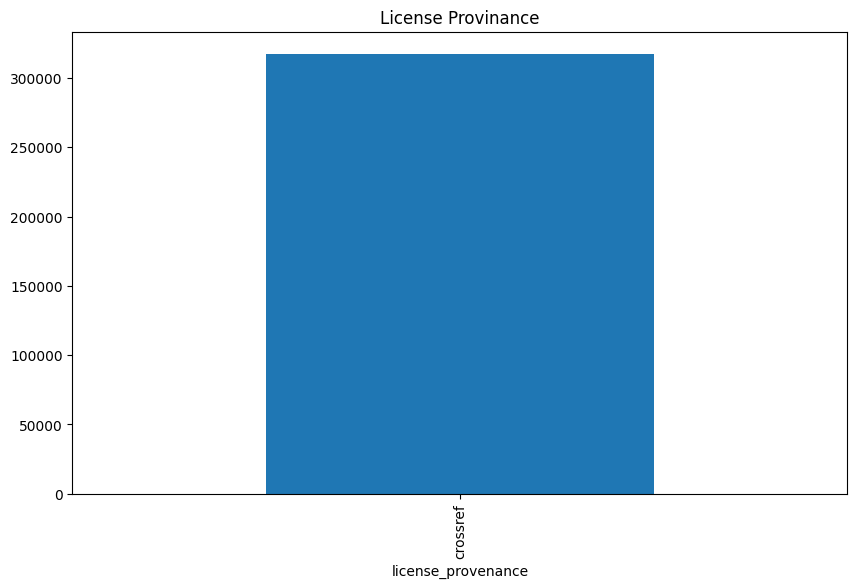

In [27]:
license_pro = df['license_provenance'].value_counts()
plt.figure(figsize=(10,6))
license_pro.plot(kind='bar')
plt.title('License Provinance')
#plt.xlabel('Licence')
plt.show()

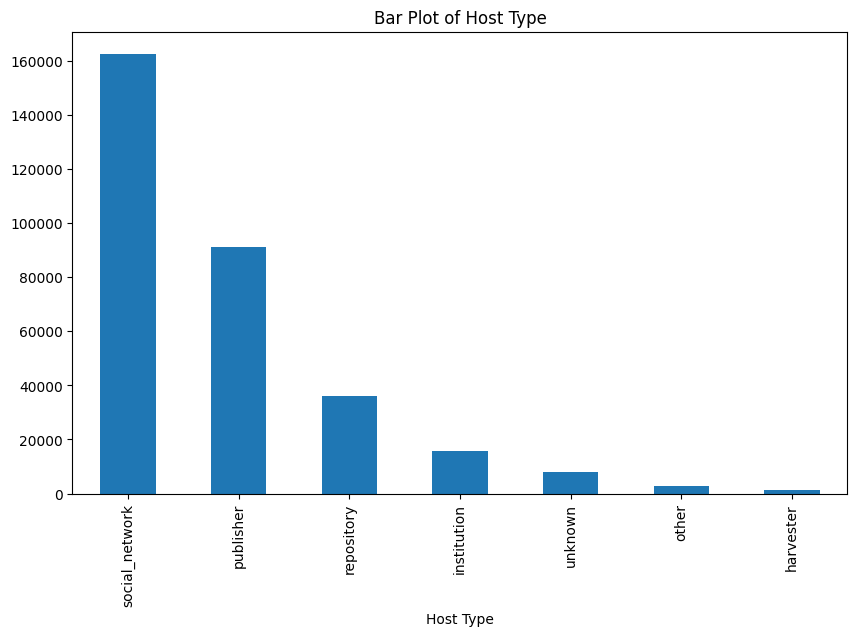

In [28]:
host_tp = df['host_type'].value_counts()
plt.figure(figsize=(10,6))
host_tp.plot(kind = 'bar')
plt.title('Bar Plot of Host Type')
plt.xlabel('Host Type')
plt.show()

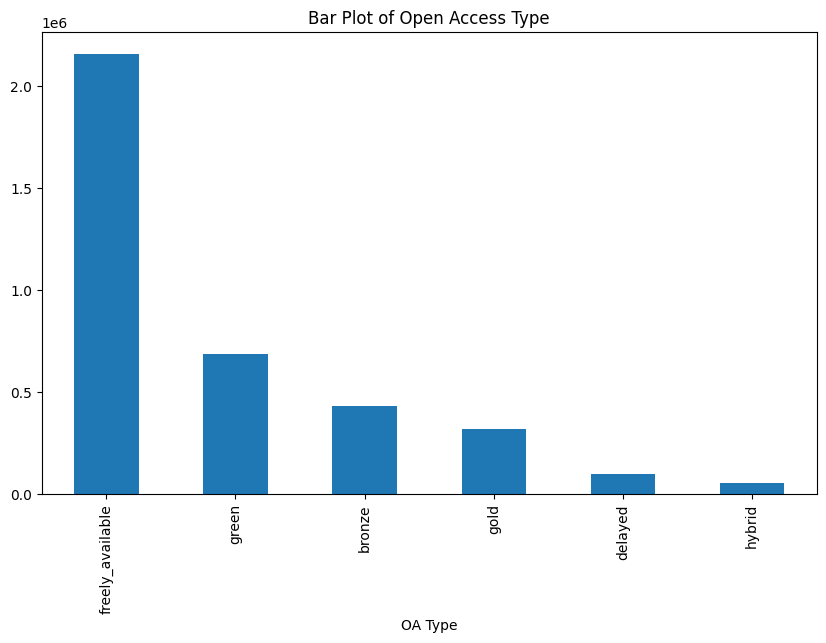

In [29]:
oatype = df2['oa_type'].value_counts()
plt.figure(figsize=(10,6))
oatype.plot(kind = 'bar')
plt.title('Bar Plot of Open Access Type')
plt.xlabel('OA Type')
plt.show()

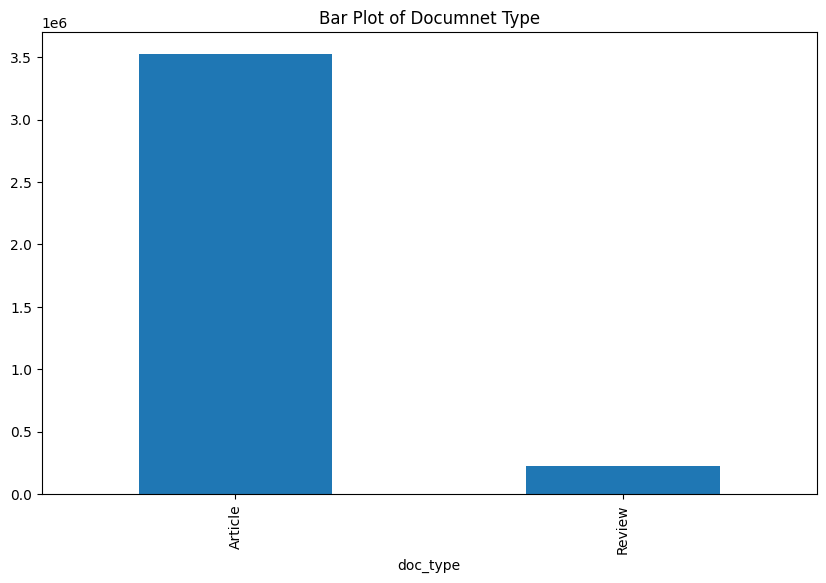

In [30]:
doctype = df2['doc_type'].value_counts()
plt.figure(figsize=(10,6))
doctype.plot(kind = 'bar')
plt.title('Bar Plot of Documnet Type')
plt.xlabel('doc_type')
plt.show()

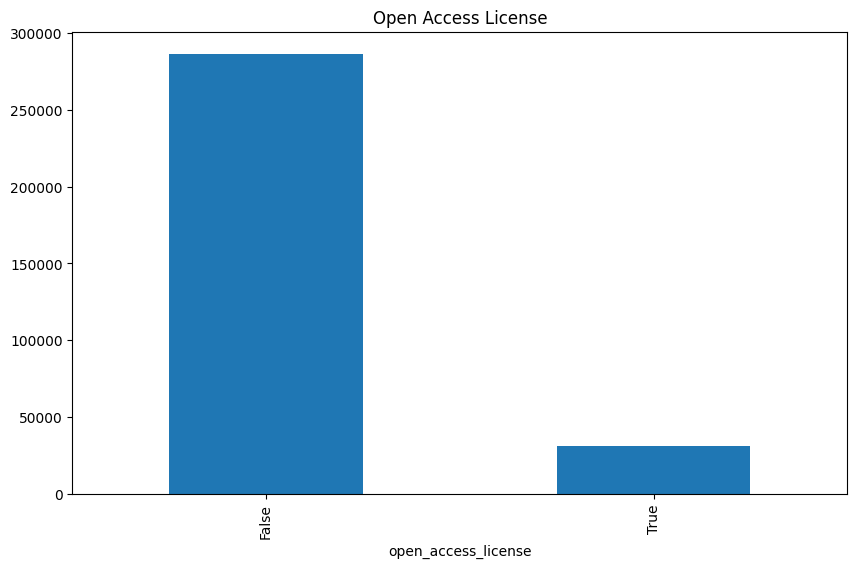

In [31]:
openaccesslicense = df['open_access_license'].value_counts()
plt.figure(figsize=(10,6))
openaccesslicense.plot(kind='bar')
plt.title('Open Access License')
#plt.xlabel('Licence')
plt.show()

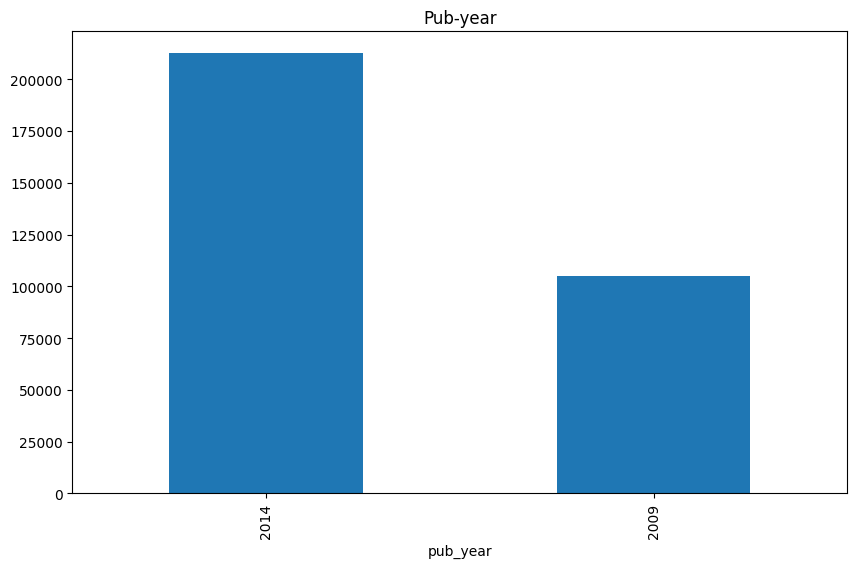

In [32]:
pubyear = df['pub_year'].value_counts()
plt.figure(figsize=(10,6))
pubyear.plot(kind='bar')
plt.title('Pub-year')
#plt.xlabel('Licence')
plt.show()

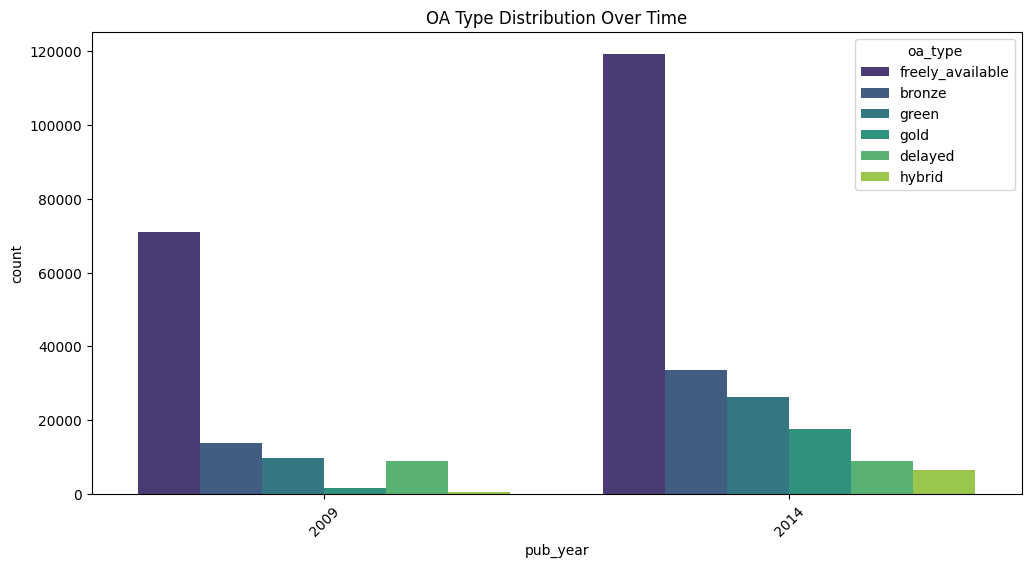

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(x='pub_year', hue='oa_type', data=df, palette='viridis')
plt.title("OA Type Distribution Over Time")
plt.xticks(rotation=45)
plt.show()

C:\Users\DellLocal\AppData\Local\Temp\ipykernel_52708\575591563.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='license', order=df['license'].value_counts().index, palette='viridis')


Text(0.5, 1.0, 'Distribution of License Types')

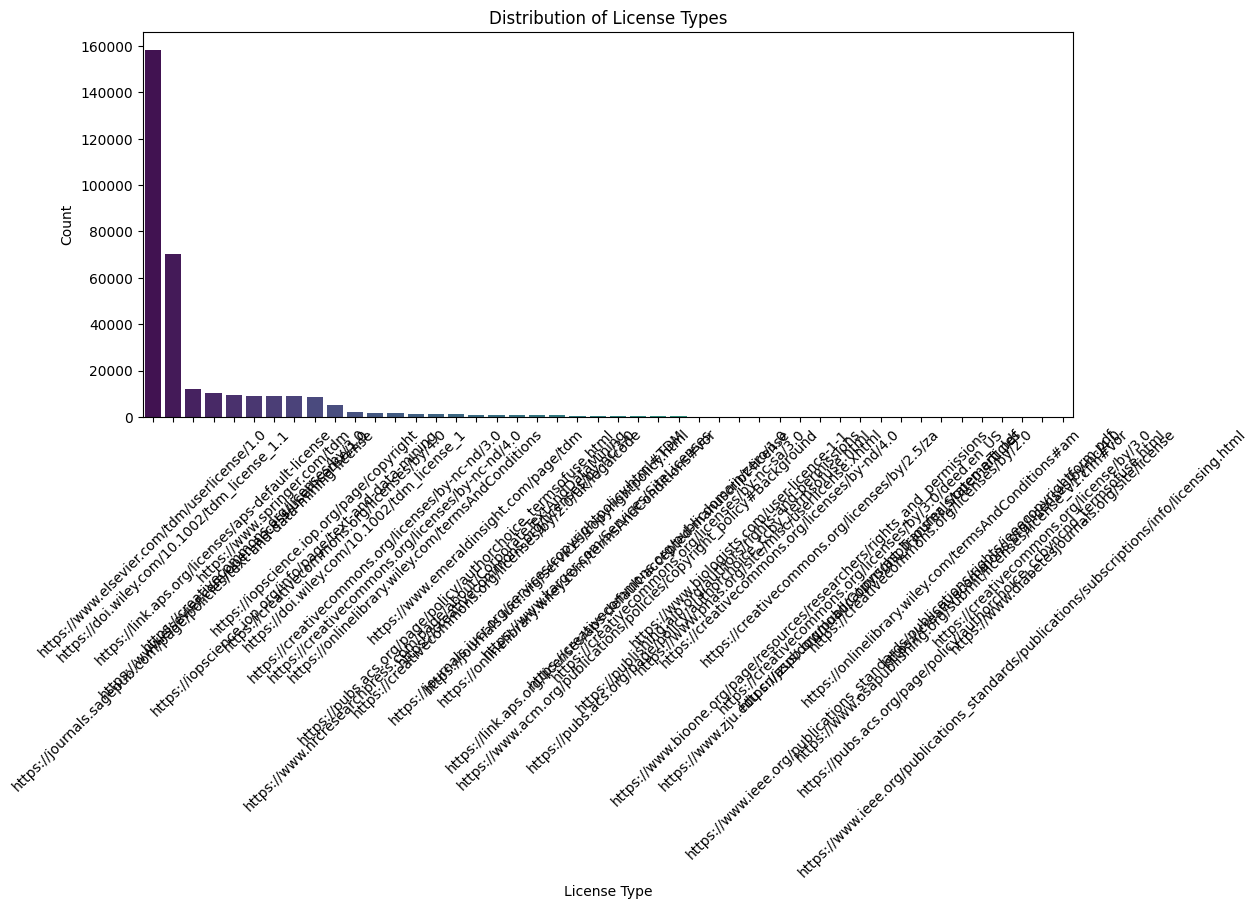

In [34]:
plt.figure(figsize=(12, 5))

# Bar Chart
sns.countplot(data=df, x='license', order=df['license'].value_counts().index, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('License Type')
plt.ylabel('Count')
plt.title('Distribution of License Types')

# Pie Chart


C:\Users\DellLocal\AppData\Local\Temp\ipykernel_52708\3430333079.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


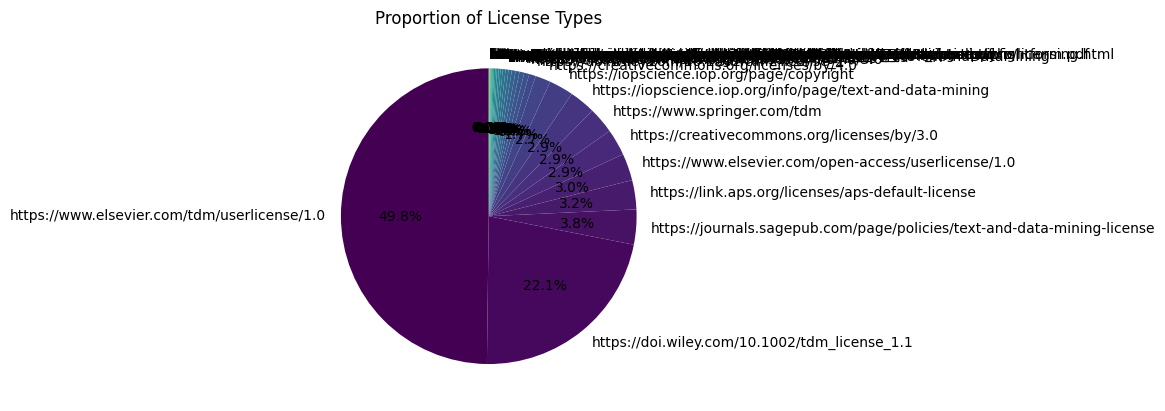

In [35]:
#Pie Chart
df['license'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.ylabel('')
plt.title('Proportion of License Types')

plt.tight_layout()
plt.show()

C:\Users\DellLocal\AppData\Local\Temp\ipykernel_52708\3516602612.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_licenses.index, y=top_licenses.values, palette='viridis')


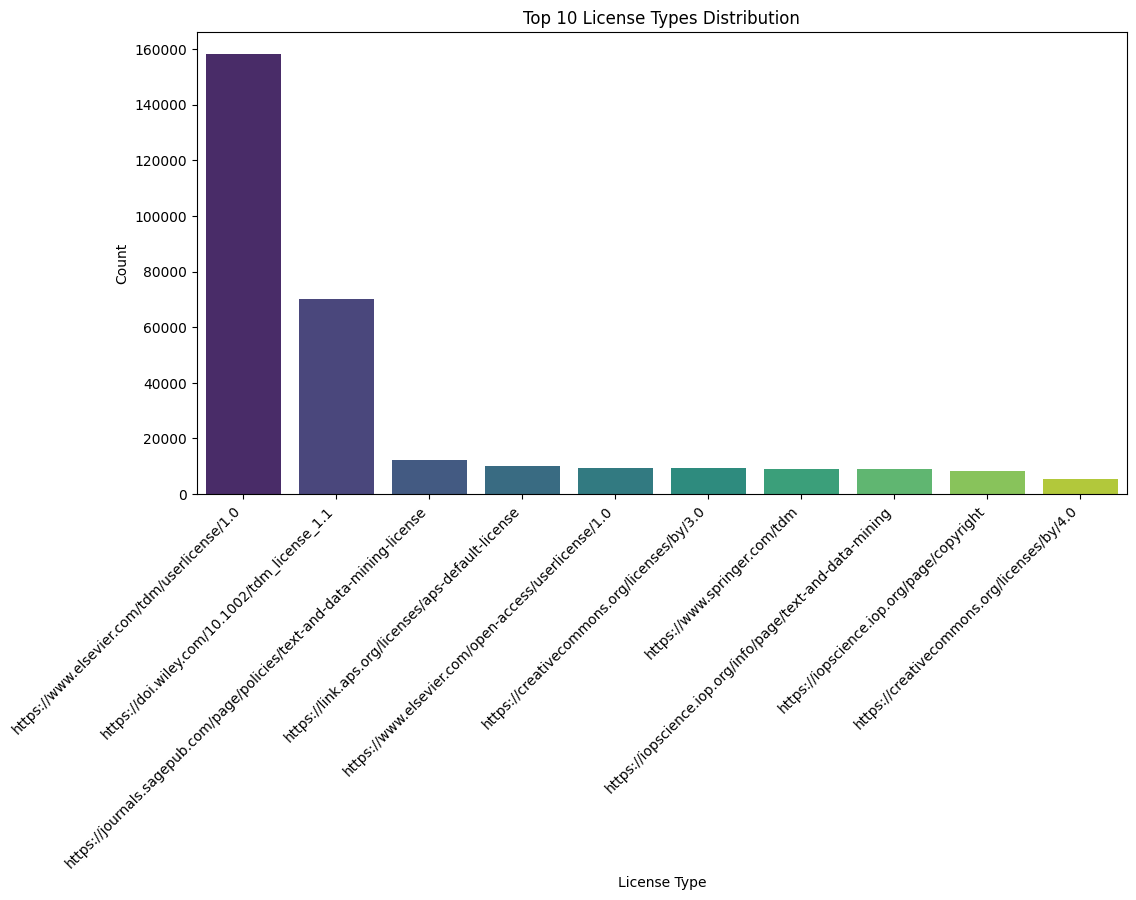

In [36]:
top_licenses = df['license'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))

# Bar Chart
sns.barplot(x=top_licenses.index, y=top_licenses.values, palette='viridis')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better readability
plt.xlabel('License Type')
plt.ylabel('Count')
plt.title('Top 10 License Types Distribution')

plt.show()

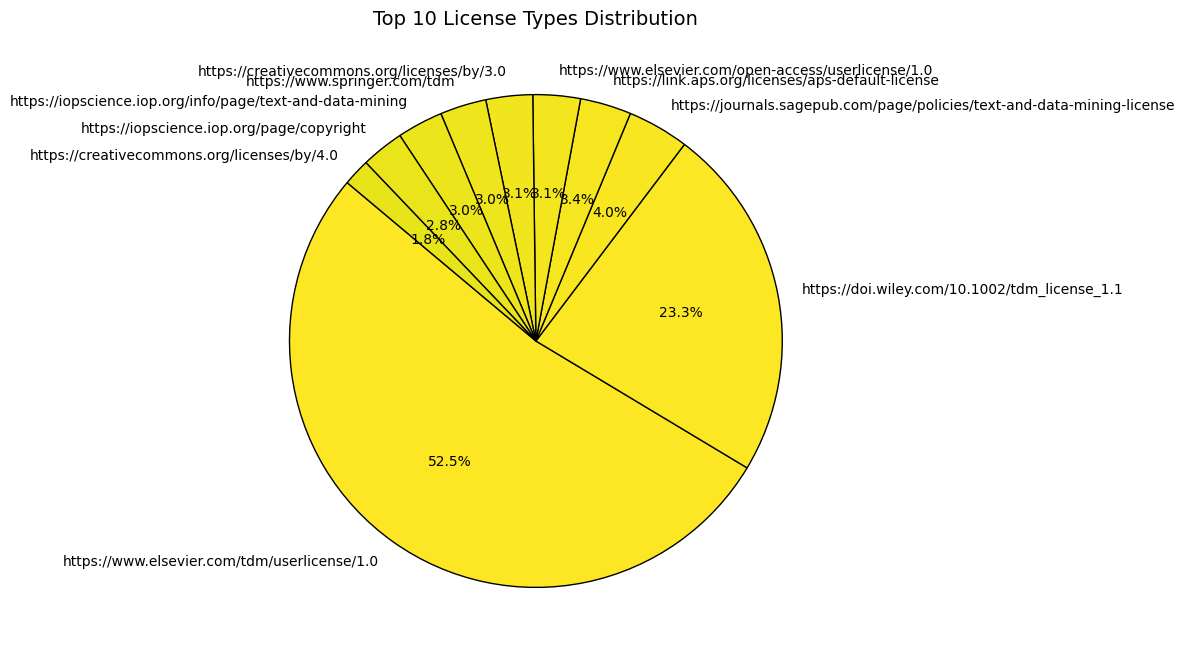

In [37]:
top_licenses = df['license'].value_counts().nlargest(10)

# Plot Pie Chart
plt.figure(figsize=(8, 8))
colors = plt.cm.viridis_r(range(len(top_licenses)))  # Custom color map

plt.pie(
    top_licenses.values, 
    labels=top_licenses.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    wedgeprops={'edgecolor': 'black'},  # Add edge for better visibility
    textprops={'fontsize': 10}  # Adjust text size for clarity
)

plt.title("Top 10 License Types Distribution", fontsize=14)
plt.show()

C:\Users\DellLocal\AppData\Local\Temp\ipykernel_52708\535670663.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=host_counts.index, y=host_counts.values, palette="viridis")


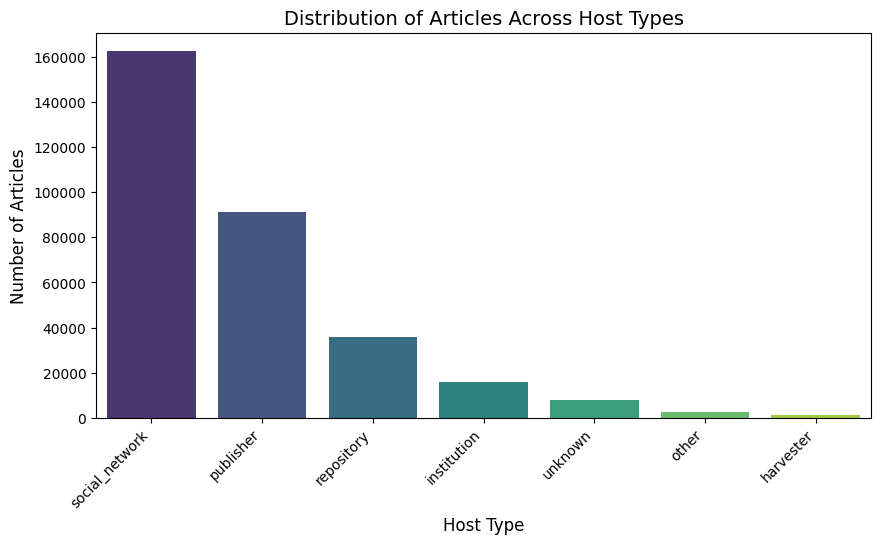

In [38]:
host_counts = df['host_type'].value_counts()

# Plot Bar Chart
plt.figure(figsize=(10, 5))
sns.barplot(x=host_counts.index, y=host_counts.values, palette="viridis")

# Rotate x-axis labels for clarity
plt.xticks(rotation=45, ha='right')

# Labels and Title
plt.xlabel("Host Type", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.title("Distribution of Articles Across Host Types", fontsize=14)

plt.show()

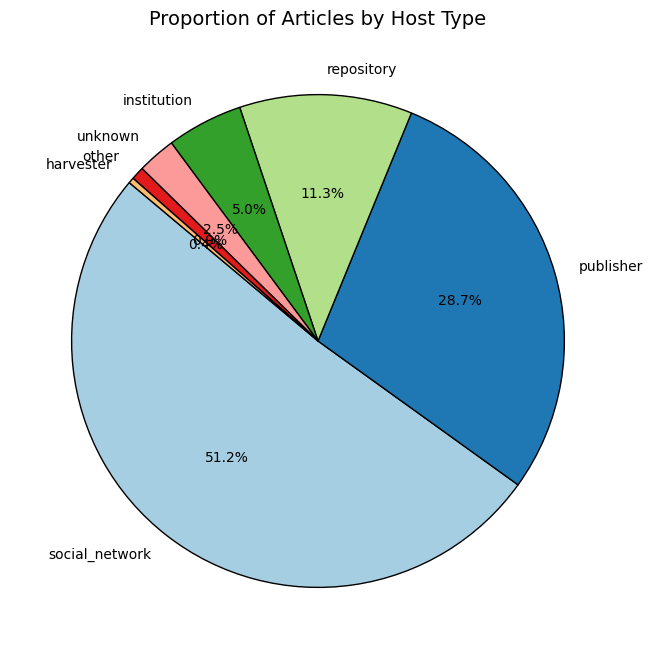

In [39]:
plt.figure(figsize=(8, 8))
colors = plt.cm.Paired(range(len(host_counts)))  

plt.pie(
    host_counts, 
    labels=host_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    wedgeprops={'edgecolor': 'black'},  
    textprops={'fontsize': 10}  
)

plt.title("Proportion of Articles by Host Type", fontsize=14)
plt.show()

In [40]:
df['log_delay'] = np.log1p(df['delay'])  # Log-transform delay to normalize distribution

# Encoding categorical variables using Label Encoding
categorical_cols = ['license', 'license_provenance', 'open_access_license', 'doc_type', 'journal', 'host', 'host_type', 'fa_url', 'prim_fa_url', 'only_source']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le

C:\Users\DellLocal\AppData\Local\Temp\ipykernel_52708\2270576615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_delay'] = np.log1p(df['delay'])  # Log-transform delay to normalize distribution
C:\Users\DellLocal\AppData\Local\Temp\ipykernel_52708\2270576615.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col].astype(str))  # Convert to string before encoding
C:\Users\DellLocal\AppData\Local\Temp\ipykernel_52708\2270576615.py:8: SettingWithCopyWarning: 
A value 

In [41]:
df.sample(5)

,doi,license,delay,license_provenance,open_access_license,doc_type,journal,pub_year,fa_url,host,prim_fa_url,host_type,oa_type,only_source,log_delay
1382859,10.1139/cjp-2013-0451,41,0.0,0,0,0,720,2014,1068,327,1,2,freely_available,1,0.000000
2960506,10.1016/j.applanim.2009.07.003,36,0.0,0,0,0,314,2009,227599,10561,1,5,freely_available,1,0.000000
1110571,10.1111/bjd.12953,16,393.0,0,0,0,664,2014,212940,10561,1,5,freely_available,1,5.976351
178764,10.1016/j.vacuum.2014.07.019,36,0.0,0,0,0,4398,2014,243736,10561,1,5,freely_available,1,0.000000
3387257,10.1016/j.jevs.2013.07.017,36,0.0,0,0,0,2423,2014,165254,10561,1,5,freely_available,1,0.000000


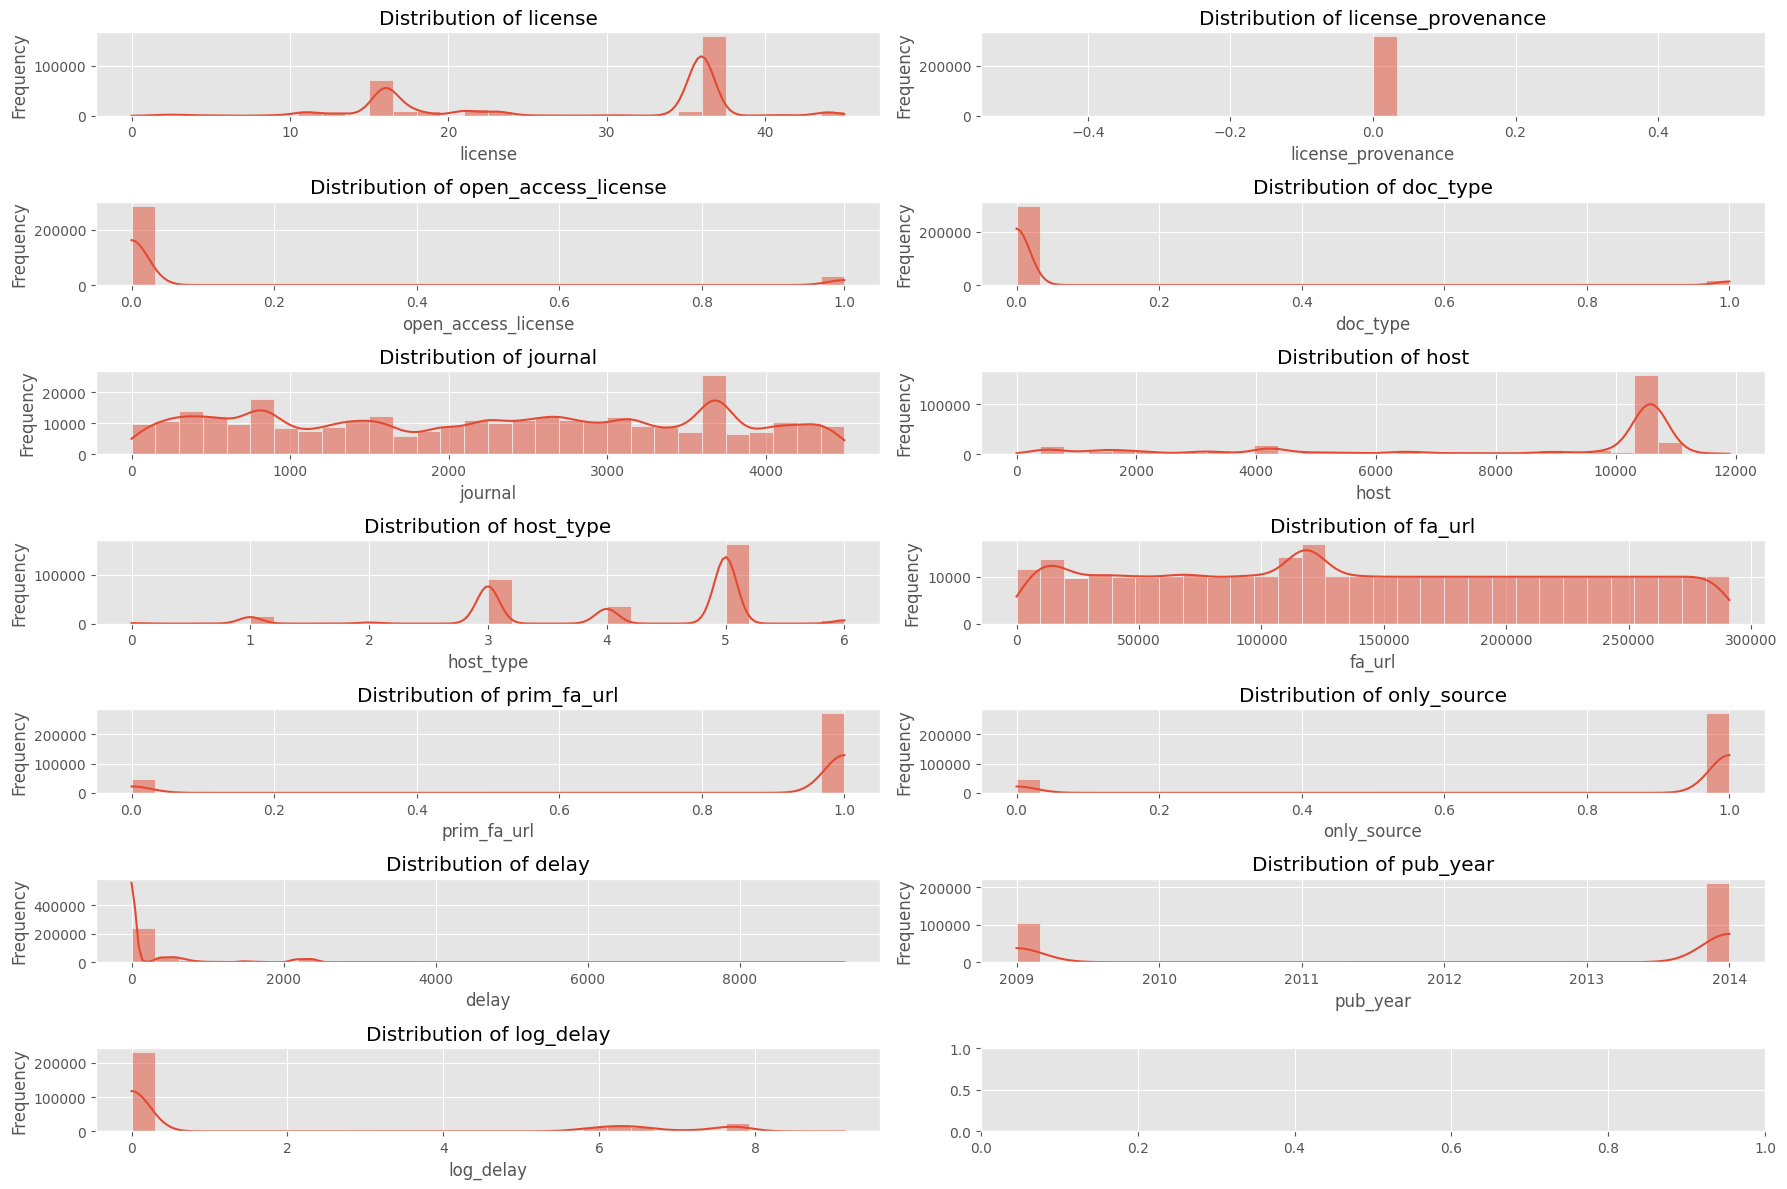

In [42]:
plt.style.use('ggplot')  # Use a default Matplotlib style
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(18, 12))  # Adjust based on the number of categories
axes = axes.flatten()
numerical_cols = ['delay', 'pub_year', 'log_delay']

for i, col in enumerate(categorical_cols+numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

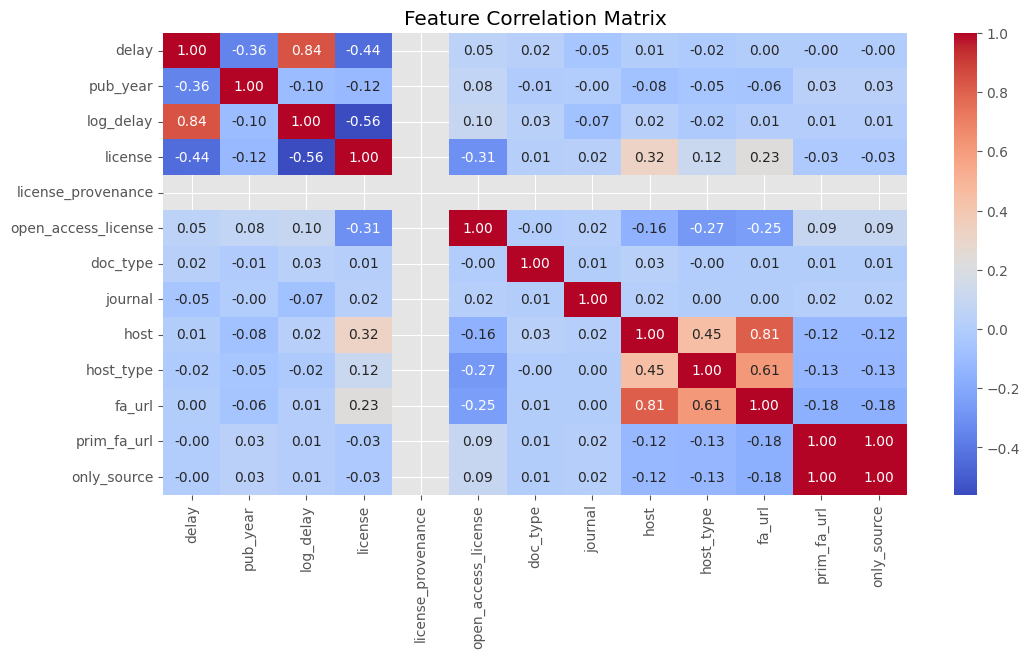

In [43]:
corr_matrix = df[numerical_cols + categorical_cols].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [44]:
'''

By Corrilation Matrix we can say
Independent Variables : License Provinance
DOI : it is unique for every paper, So it wont show any effect of changing the target variable


'''

'\n\nBy Corrilation Matrix we can say\nIndependent Variables : License Provinance\nDOI : it is unique for every paper, So it wont show any effect of changing the target variable\n\n\n'

## Probelm Statement:
Here 2 tasks we have to complete

1. Classification Task: Predict oa_type (Gold, Green, Hybrid, Closed) using categorical features.

2. Regression Task: Predict delay (accessibility delay) using categorical features.



In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import lightgbm as lgb


In [46]:
df.head()

,doi,license,delay,license_provenance,open_access_license,doc_type,journal,pub_year,fa_url,host,prim_fa_url,host_type,oa_type,only_source,log_delay
5689,10.1002/2012jb009826,16,577.0,0,0,0,2493,2014,46905,4223,1,3,bronze,1,6.359574
5690,10.1002/2012jb010016,16,608.0,0,0,0,2493,2014,46906,4223,1,3,bronze,1,6.411818
5710,10.1002/2012jd019347,15,0.0,0,0,0,2488,2014,46907,4223,1,3,bronze,1,0.000000
5711,10.1002/2012jd019347,24,0.0,0,0,0,2488,2014,46907,4223,1,3,bronze,1,0.000000
5726,10.1002/2012jg002133,16,549.0,0,0,0,2489,2014,46908,4223,1,3,bronze,1,6.309918


#### Classification of oa_type

In [47]:

# Define features (categorical columns) and target
X = df.drop(columns=['oa_type', 'delay','doi'])  # Drop target variables
y = df['oa_type']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [48]:
# mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Correct Label Encoding Mapping:")
# for category, encoded in mapping.items():
#     print(f"'{category}' -> {encoded}")


In [49]:
X_test.head(2)

,license,license_provenance,open_access_license,doc_type,journal,pub_year,fa_url,host,prim_fa_url,host_type,only_source,log_delay
3258856,36,0,0,0,1675,2014,161799,10561,0,5,0,0.0
1579059,21,0,0,0,1732,2014,187924,10561,1,5,1,0.0


In [50]:
y_test.head(2)

3258856    freely_available
1579059    freely_available
Name: oa_type, dtype: object

Random Forest Classifier: 
Accuracy :  0.9957178841309824
{'bronze': {'precision': 0.994089709762533, 'recall': 0.9948246725813266, 'f1-score': 0.9944570553766563, 'support': 9468.0}, 'delayed': {'precision': 0.9732620320855615, 'recall': 0.9721675569299972, 'f1-score': 0.9727144866385373, 'support': 3557.0}, 'freely_available': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 38079.0}, 'gold': {'precision': 0.9940166493236212, 'recall': 0.9940166493236212, 'f1-score': 0.9940166493236212, 'support': 3844.0}, 'green': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7174.0}, 'hybrid': {'precision': 0.9297491039426523, 'recall': 0.9277539341917024, 'f1-score': 0.9287504475474401, 'support': 1398.0}, 'accuracy': 0.9957178841309824, 'macro avg': {'precision': 0.9818529158523946, 'recall': 0.9814604688377747, 'f1-score': 0.9816564398143758, 'support': 63520.0}, 'weighted avg': {'precision': 0.9957135338078059, 'recall': 0.9957178841309824, 'f1-score': 0.99571564790

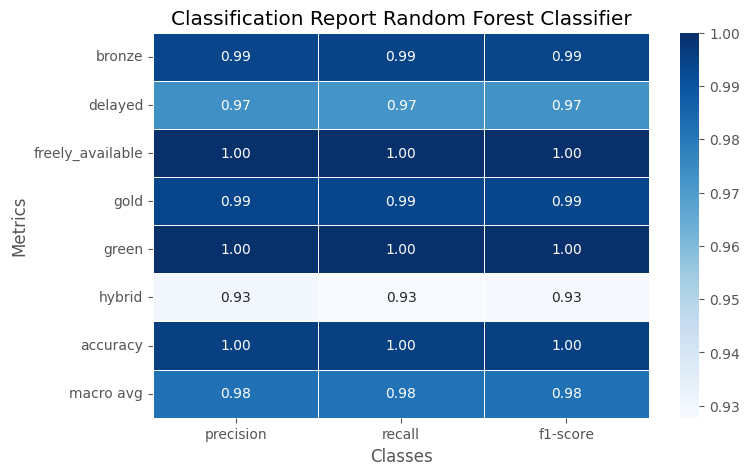

--------------------------------------------------


In [51]:
model1 = RandomForestClassifier(n_estimators=200,random_state=42)
model1.fit(X_train,y_train)
y_pred = model1.predict(X_test)
print('Random Forest Classifier: ')
print('Accuracy : ',accuracy_score(y_test, y_pred))
report_dict = classification_report(y_test, y_pred, output_dict=True)
print(report_dict)
report_df = pd.DataFrame(report_dict).transpose()
    
# Plot Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title(f"Classification Report Random Forest Classifier")
plt.ylabel("Metrics")
plt.xlabel("Classes")
plt.show()
        
print("-" * 50)

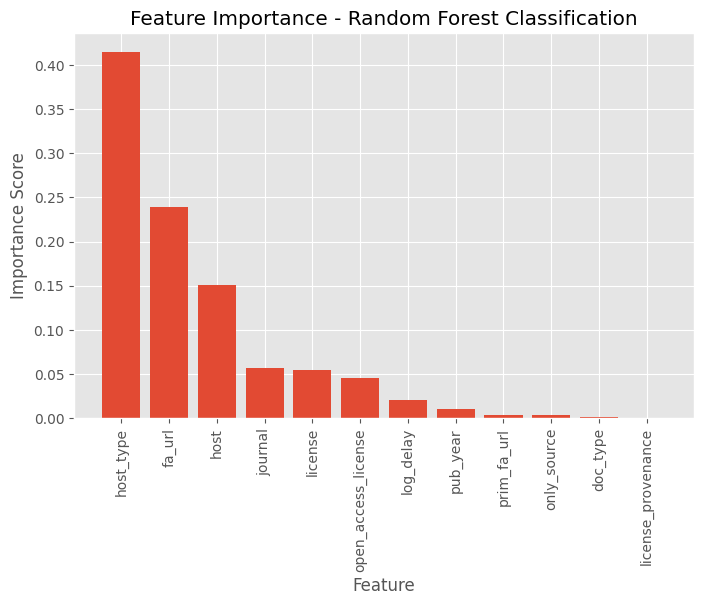

In [52]:
importances = model1.feature_importances_
features = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot Feature Importance
plt.figure(figsize=(8,5))
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance - Random Forest Classification")
plt.show()

In [53]:
task1 = np.array([36, 0, 0, 0, 1675, 2014, 161799, 10561, 0, 5, 0, 0.0])  # Corrected syntax
task1 = task1.reshape(1, -1)  # Reshape to 2D array

out1 = model1.predict(task1)  # Predict
print(out1)

['freely_available']


c:\Users\DellLocal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale X
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [55]:
print("Shape of X_scaled:", X_scaled.shape)
print("Shape of y:", y.shape)


Shape of X_scaled: (317598, 12)
Shape of y: (317598,)


K-Neighbours Classifier: 
Accuracy :  0.9935925692695214
{'bronze': {'precision': 0.9895547583878456, 'recall': 0.9905999155048585, 'f1-score': 0.990077061121081, 'support': 9468.0}, 'delayed': {'precision': 0.9646436525612472, 'recall': 0.9741355074500984, 'f1-score': 0.9693663449433487, 'support': 3557.0}, 'freely_available': {'precision': 0.9997636616685486, 'recall': 0.9998161716431629, 'f1-score': 0.9997899159663866, 'support': 38079.0}, 'gold': {'precision': 0.9817660849179474, 'recall': 0.9804890738813735, 'f1-score': 0.9811271638682806, 'support': 3844.0}, 'green': {'precision': 0.9984664714903109, 'recall': 0.9983272930025091, 'f1-score': 0.9983968773959713, 'support': 7174.0}, 'hybrid': {'precision': 0.9329403095062638, 'recall': 0.9055793991416309, 'f1-score': 0.9190562613430127, 'support': 1398.0}, 'accuracy': 0.9935925692695214, 'macro avg': {'precision': 0.9778558230886939, 'recall': 0.9748245601039388, 'f1-score': 0.9763022707730135, 'support': 63520.0}, 'weighted avg': 

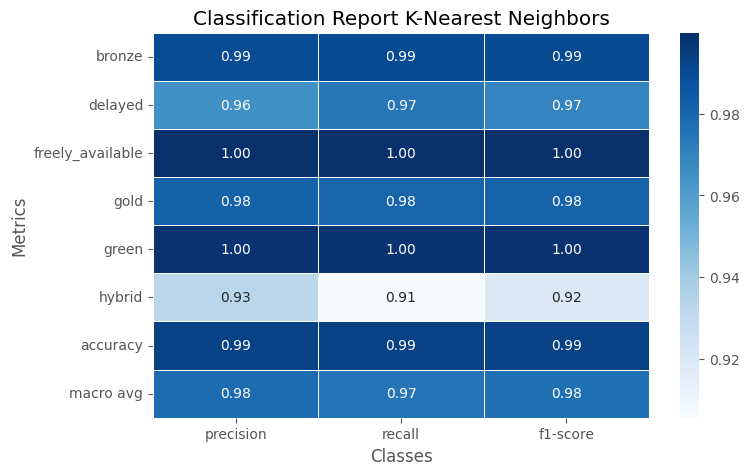

--------------------------------------------------


In [56]:
knn= KNeighborsClassifier(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)
y_knn = knn.predict(X_test)
print('K-Neighbours Classifier: ')
print('Accuracy : ',accuracy_score(y_test, y_knn))
report_dict = classification_report(y_test, y_knn, output_dict=True)
print(report_dict)
report_df = pd.DataFrame(report_dict).transpose()
    
# Plot Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title(f"Classification Report K-Nearest Neighbors")
plt.ylabel("Metrics")
plt.xlabel("Classes")
plt.show()
        
print("-" * 50)

# Predection of Delay

In [57]:
df.head()

,doi,license,delay,license_provenance,open_access_license,doc_type,journal,pub_year,fa_url,host,prim_fa_url,host_type,oa_type,only_source,log_delay
5689,10.1002/2012jb009826,16,577.0,0,0,0,2493,2014,46905,4223,1,3,bronze,1,6.359574
5690,10.1002/2012jb010016,16,608.0,0,0,0,2493,2014,46906,4223,1,3,bronze,1,6.411818
5710,10.1002/2012jd019347,15,0.0,0,0,0,2488,2014,46907,4223,1,3,bronze,1,0.000000
5711,10.1002/2012jd019347,24,0.0,0,0,0,2488,2014,46907,4223,1,3,bronze,1,0.000000
5726,10.1002/2012jg002133,16,549.0,0,0,0,2489,2014,46908,4223,1,3,bronze,1,6.309918


In [58]:
le_oa_type = LabelEncoder()

# Fit and transform the 'oa_type' column
df['oa_type_encoded'] = le_oa_type.fit_transform(df['oa_type'].astype(str))

# View the mapping of categories to numbers
label_mapping = dict(zip(le_oa_type.classes_, le_oa_type.transform(le_oa_type.classes_)))
print("Label Encoding Mapping: ", label_mapping)

# Check updated DataFrame
df.head()

Label Encoding Mapping:  {'bronze': np.int64(0), 'delayed': np.int64(1), 'freely_available': np.int64(2), 'gold': np.int64(3), 'green': np.int64(4), 'hybrid': np.int64(5)}


C:\Users\DellLocal\AppData\Local\Temp\ipykernel_52708\1776546422.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['oa_type_encoded'] = le_oa_type.fit_transform(df['oa_type'].astype(str))


,doi,license,delay,license_provenance,open_access_license,doc_type,journal,pub_year,fa_url,host,prim_fa_url,host_type,oa_type,only_source,log_delay,oa_type_encoded
5689,10.1002/2012jb009826,16,577.0,0,0,0,2493,2014,46905,4223,1,3,bronze,1,6.359574,0
5690,10.1002/2012jb010016,16,608.0,0,0,0,2493,2014,46906,4223,1,3,bronze,1,6.411818,0
5710,10.1002/2012jd019347,15,0.0,0,0,0,2488,2014,46907,4223,1,3,bronze,1,0.000000,0
5711,10.1002/2012jd019347,24,0.0,0,0,0,2488,2014,46907,4223,1,3,bronze,1,0.000000,0
5726,10.1002/2012jg002133,16,549.0,0,0,0,2489,2014,46908,4223,1,3,bronze,1,6.309918,0


In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



X_reg = df.drop(columns=['delay','log_delay','doi','oa_type'])  # Drop target variable
y_reg = df['delay']

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)



In [60]:
X_train

,license,license_provenance,open_access_license,doc_type,journal,pub_year,fa_url,host,prim_fa_url,host_type,only_source,oa_type_encoded
1256252,16,0,0,0,3003,2014,88707,7852,1,4,1,4
664149,17,0,0,0,421,2014,7044,506,1,4,1,4
3051846,36,0,0,0,745,2014,183568,10561,1,5,1,2
3219535,36,0,0,0,1499,2014,279898,10561,1,5,1,2
1195462,16,0,0,0,2667,2009,59422,4223,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1259214,16,0,0,0,3111,2014,163412,10561,0,5,0,2
3382117,36,0,0,0,2419,2014,169209,10561,1,5,1,2
1479373,11,0,1,0,3143,2014,91844,8516,1,3,1,3
1848592,16,0,0,0,3839,2014,242258,10561,1,5,1,2


In [61]:
y_train

1256252     509.0
664149        0.0
3051846       0.0
3219535       0.0
1195462    2314.0
            ...  
1259214     810.0
3382117       0.0
1479373       0.0
1848592     503.0
1265815     411.0
Name: delay, Length: 254078, dtype: float64

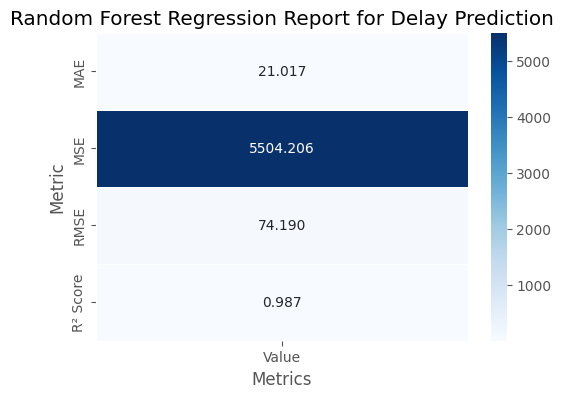

In [62]:
reg = RandomForestRegressor(n_estimators=200,random_state=42)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
metrics_dict = {
    "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
    "Value": [mae, mse, rmse, r2]
}
metrics_df = pd.DataFrame(metrics_dict)

# MAE - Mean Absolute Error
# MSE - Mean Square Error

# Plot Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(metrics_df.set_index("Metric"), annot=True, cmap="Blues", fmt=".3f", linewidths=0.5)
plt.title(f"Random Forest Regression Report for Delay Prediction")
plt.xlabel("Metrics")
plt.show()

In [63]:
regg1 = np.array([[16,0,0,0,3003,2014,88707,7852,1,4,1,4]])
reg.predict(regg1)

c:\Users\DellLocal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([527.155])

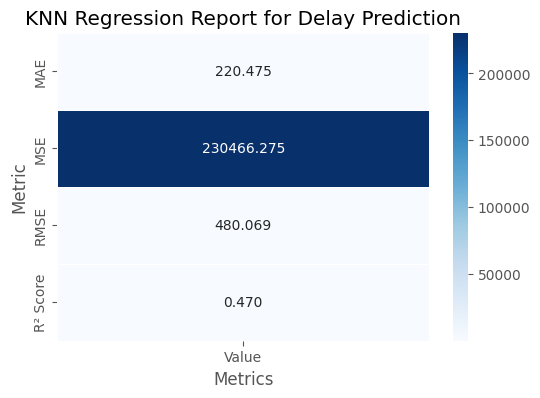

In [64]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_reg.fit(X_train, y_train)  # Ensure y_train is 'delay'

# Predictions
y_pred_knn = knn_reg.predict(X_test)

# Compute Regression Metrics
mae = mean_absolute_error(y_test, y_pred_knn)
mse = mean_squared_error(y_test, y_pred_knn)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_knn)

# Convert Metrics into a DataFrame for Heatmap
metrics_dict = {
    "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
    "Value": [mae, mse, rmse, r2]
}
metrics_df = pd.DataFrame(metrics_dict)

# Plot Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(metrics_df.set_index("Metric"), annot=True, cmap="Blues", fmt=".3f", linewidths=0.5)
plt.title(f"KNN Regression Report for Delay Prediction")
plt.xlabel("Metrics")
plt.show()

In [65]:
knn_reg.predict(regg1)

c:\Users\DellLocal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


array([509.])